# I use google colab to run this notebook so that I can use GPU for PINNsFormer

In [1]:
!git clone https://github.com/AdityaLab/pinnsformer.git

Cloning into 'pinnsformer'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 139 (delta 42), reused 4 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (139/139), 24.77 MiB | 8.84 MiB/s, done.
Resolving deltas: 100% (42/42), done.


In [4]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS
from tqdm import tqdm
import scipy
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/cse598/cse598/cse598/hw1/pinnsformer')
from util import *
from model.pinn import PINNs
from model.pinnsformer import PINNsformer


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
device

device(type='cuda')

In [7]:
def function(u0: str):
    """Initial condition, string --> function."""

    if u0 == 'sin(x)':
        u0 = lambda x: np.sin(x)
    elif u0 == 'sin(pix)':
        u0 = lambda x: np.sin(np.pi*x)
    elif u0 == 'sin^2(x)':
        u0 = lambda x: np.sin(x)**2
    elif u0 == 'sin(x)cos(x)':
        u0 = lambda x: np.sin(x)*np.cos(x)
    elif u0 == '0.1sin(x)':
        u0 = lambda x: 0.1*np.sin(x)
    elif u0 == '0.5sin(x)':
        u0 = lambda x: 0.5*np.sin(x)
    elif u0 == '10sin(x)':
        u0 = lambda x: 10*np.sin(x)
    elif u0 == '50sin(x)':
        u0 = lambda x: 50*np.sin(x)
    elif u0 == '1+sin(x)':
        u0 = lambda x: 1 + np.sin(x)
    elif u0 == '2+sin(x)':
        u0 = lambda x: 2 + np.sin(x)
    elif u0 == '6+sin(x)':
        u0 = lambda x: 6 + np.sin(x)
    elif u0 == '10+sin(x)':
        u0 = lambda x: 10 + np.sin(x)
    elif u0 == 'sin(2x)':
        u0 = lambda x: np.sin(2*x)
    elif u0 == 'tanh(x)':
        u0 = lambda x: np.tanh(x)
    elif u0 == '2x':
        u0 = lambda x: 2*x
    elif u0 == 'x^2':
        u0 = lambda x: x**2
    elif u0 == 'gauss':
        x0 = np.pi
        sigma = np.pi/4
        u0 = lambda x: np.exp(-np.power((x - x0)/sigma, 2.)/2.)
    return u0

def reaction(u, rho, dt):
    """ du/dt = rho*u*(1-u)
    """
    factor_1 = u * np.exp(rho * dt)
    factor_2 = (1 - u)
    u = factor_1 / (factor_2 + factor_1)
    return u

def diffusion(u, nu, dt, IKX2):
    """ du/dt = nu*d2u/dx2
    """
    factor = np.exp(nu * IKX2 * dt)
    u_hat = np.fft.fft(u)
    u_hat *= factor
    u = np.real(np.fft.ifft(u_hat))
    return u

def reaction_diffusion_discrete_solution(u0 : str, nu, rho, nx = 256, nt = 100):
    """ Computes the discrete solution of the reaction-diffusion PDE using
        pseudo-spectral operator splitting.
    Args:
        u0: initial condition
        nu: diffusion coefficient
        rho: reaction coefficient
        nx: size of x-tgrid
        nt: number of points in the t grid
    Returns:
        u: solution
    """
    L = 2*np.pi
    T = 1
    dx = L/nx
    dt = T/nt
    x = np.arange(0, L, dx) # not inclusive of the last point
    t = np.linspace(0, T, nt).reshape(-1, 1)
    X, T = np.meshgrid(x, t)
    u = np.zeros((nx, nt))
    k = np.fft.fftfreq(nx, d=dx) * 2 * np.pi
    IKX = 1j * k
    IKX2 = IKX * IKX

    # call u0 this way so array is (n, ), so each row of u should also be (n, )
    u0 = function(u0)
    u0 = u0(x)

    u[:,0] = u0
    u_ = u0
    for i in range(nt-1):
        u_ = reaction(u_, rho, dt)
        u_ = diffusion(u_, nu, dt, IKX2)
        u[:,i+1] = u_

    # u = u.T
    # u = u.flatten()
    return u


# Load numerical solution data from the file
L = 2*np.pi
T = 1
dx = L/256
x = np.arange(0, L, dx).reshape(-1, 1) # not inclusive of the last point
t = np.linspace(0, T, 100).reshape(-1, 1)
u0_str = 'sin(x)'
nu = 4.25
rho = 1.75

usol = reaction_diffusion_discrete_solution(u0_str, nu, rho, 256, 100)                         # solution of 256x100 grid points
X, T = np.meshgrid(x,t)

In [8]:
!pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18171 sha256=028ac375a2754f816dc99b45d5dc5810631499ba9585e3d6b7c82640b25efbc5
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


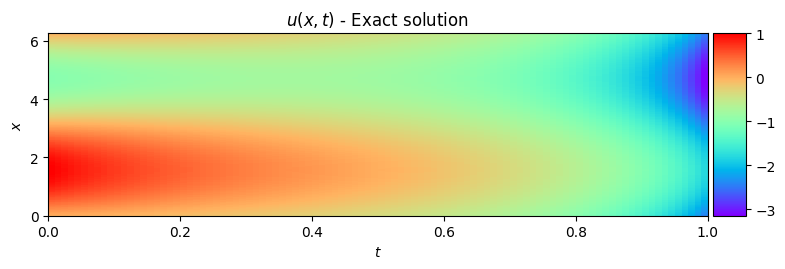

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
from pyDOE import lhs  # Latin Hypercube Sampling for colocation points
import scipy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

def solution_plot(u_pred, usol, x, t, X, T, X_u_train, u_train):

    fig = plt.figure(figsize=(9, 9))  # Adjust the figure size
    gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1])
    fig.subplots_adjust(hspace=0.4)  # Add more space between subplots

    # Plot u(x, t)
    ax = plt.subplot(gs[0])
    h = ax.imshow(u_pred, interpolation='nearest', cmap='rainbow',
                  extent=[T.min(), T.max(), X.min(), X.max()],
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)

    ax.plot(X_u_train[:, 1], X_u_train[:, 0], 'kx',
            label='Data (%d points)' % u_train.shape[0],
            markersize=4, clip_on=False)

    for time_step in [25, 50, 75]:
        ax.plot(t[time_step] * np.ones((2, 1)), np.linspace(x.min(), x.max(), 2),
                'w-', linewidth=1)

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc='upper right')
    ax.set_title('$u(x,t)$ - PINN solution', fontsize=12)

    # Plot error
    ax = plt.subplot(gs[1])
    error = np.abs(usol - u_pred)
    h = ax.imshow(error, interpolation='nearest', cmap='rainbow',
                  extent=[T.min(), T.max(), X.min(), X.max()],
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)

    ax.plot(X_u_train[:, 1], X_u_train[:, 0], 'kx',
            label='Data (%d points)' % u_train.shape[0],
            markersize=4, clip_on=False)

    for time_step in [25, 50, 75]:
        ax.plot(t[time_step] * np.ones((2, 1)), np.linspace(x.min(), x.max(), 2),
                'w-', linewidth=1)

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc='best')
    ax.set_title('Error', fontsize=12)

    # u(x,t) slices
    gs2 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[2], wspace=0.5)

    time_steps = [25, 50, 75]
    titles = ['$t = 0.25s$', '$t = 0.50s$', '$t = 0.75s$']

    for i, time_step in enumerate(time_steps):
        ax = plt.subplot(gs2[0, i])
        ax.plot(x, usol.T[time_step, :], 'b-', linewidth=2, label='Exact')
        ax.plot(x, u_pred.T[time_step, :], 'r--', linewidth=2, label='Prediction')
        ax.set_xlabel('$x$')
        ax.set_ylabel('$u(x,t)$')
        ax.set_xlim([-1.1, 1.1])
        ax.set_ylim([-1.1, 1.1])
        ax.set_title(titles[i], fontsize=10)
        ax.axis('square')

        if i == 1:
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=2, frameon=False)

    plt.show()

def plot_exact_solution(usol, X, T):

    fig = plt.figure(figsize=(9, 9))  # Adjust the figure size
    gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1])
    fig.subplots_adjust(hspace=0.4)  # Add more space between subplots

    # Plot u(x, t)
    ax = plt.subplot(gs[0])
    h = ax.imshow(usol, interpolation='nearest', cmap='rainbow',
                  extent=[T.min(), T.max(), X.min(), X.max()],
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc='upper right')
    ax.set_title('$u(x,t)$ - Exact solution', fontsize=12)

    plt.show()

plot_exact_solution(usol, X, T)

In [12]:
# Generate training data (boundary and initial conditions)
N_u = 100  # Number of boundary condition points
N_f = 10_00  # Number of colocation points

lower_bound = np.array([X.min(), T.min()])  # [x_min, t_min] = [-1, 0]
upper_bound = np.array([X.max(), T.max()])  # [x_max, t_max] = [1, 0.99]

# Initial condition: -1 <= x <= 1, t = 0
initial_condition_xt = np.hstack((X[0, :][:, None], T[0, :][:, None]))
initial_condition_u = usol[:, 0][:, None]

# TODO: Boundary condition: x = -1, 0 <= t <= 1
boundary_left_xt = np.hstack((X[:, 0][:, None], T[:, 0][:, None]))
boundary_left_u = usol[0, :][:, None]

# TODO: Boundary condition: x = 1, 0 <= t <= 1
boundary_right_xt =  np.hstack((X[:, -1][:, None], T[:, -1][:, None]))
boundary_right_u = usol[-1, :][:, None]

# Combine boundary and initial condition points
all_xt_u_train = np.vstack([initial_condition_xt, boundary_left_xt, boundary_right_xt])
all_u_train = np.vstack([initial_condition_u, boundary_left_u, boundary_right_u])


# TODO: Select N_u random points for training
selected_indices = np.random.randint(0, all_u_train.shape[0], N_u)

Xt_u_train = all_xt_u_train[selected_indices, :]
u_train = all_u_train[selected_indices, :]


ic_idx = selected_indices[selected_indices < usol.shape[0]]
bcl_idx = selected_indices[(selected_indices >= usol.shape[0])  & (selected_indices < (usol.shape[0]+usol.shape[1]))]
bcr_idx = selected_indices[(selected_indices >= (usol.shape[0]+usol.shape[1]))  & (selected_indices < (usol.shape[0]+2*usol.shape[1]))]


In [13]:
from scipy.stats import qmc

# Initialize Latin Hypercube Sampler
sampler = qmc.LatinHypercube(d=2)  # 2 dimensions: x and t
# Generate N_f samples in the unit square [0, 1] and scale to the desired domain
samples = sampler.random(n=N_f)

# TODO: Generate colocation points using Latin Hypercube Sampling
Xt_f_train = qmc.scale(samples, lower_bound, upper_bound)

b_left = make_time_sequence(all_xt_u_train[bcl_idx], num_step=5, step=1e-4)
b_right = make_time_sequence(all_xt_u_train[bcr_idx], num_step=5, step=1e-4)
ic = make_time_sequence(all_xt_u_train[ic_idx], num_step=5, step=1e-4)

b_left_u = make_time_sequence(all_u_train[bcl_idx], num_step=5, step=1e-4)
b_right_u = make_time_sequence(all_u_train[bcr_idx], num_step=5, step=1e-4)
ic_u = make_time_sequence(all_u_train[ic_idx], num_step=5, step=1e-4)

res = make_time_sequence(Xt_f_train, num_step=5, step=1e-4)

In [14]:
# Train PINNsformer
#usol_seq = torch.tensor(usol_seq, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
ic = torch.tensor(ic, dtype=torch.float32, requires_grad=True).to(device)
b_left_u = torch.tensor(b_left_u, dtype=torch.float32, requires_grad=True).to(device)
b_right_u = torch.tensor(b_right_u, dtype=torch.float32, requires_grad=True).to(device)
ic_u = torch.tensor(ic_u, dtype=torch.float32, requires_grad=True).to(device)
res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
#x_res, t_res = res[:,:,0:1], res[:,:,1:2]
x_left, t_left = b_left[:,:,0:1], b_left[:,:,1:2]
x_right, t_right = b_right[:,:,0:1], b_right[:,:,1:2]
x_lower, t_lower = ic[:,:,0:1], ic[:,:,1:2]
x_res, t_res = res[:,:,0:1], res[:,:,1:2]

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [15]:
model = PINNsformer(d_out=1, d_hidden=512, d_model=32, N=1, heads=2).to(device)

model.apply(init_weights)
optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')

print(model)
print(get_n_params(model))

<ipython-input-14-6c4027154040>:18: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  torch.nn.init.xavier_uniform(m.weight)


PINNsformer(
  (linear_emb): Linear(in_features=2, out_features=32, bias=True)
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (ff): FeedForward(
          (linear): Sequential(
            (0): Linear(in_features=32, out_features=256, bias=True)
            (1): WaveAct()
            (2): Linear(in_features=256, out_features=256, bias=True)
            (3): WaveAct()
            (4): Linear(in_features=256, out_features=32, bias=True)
          )
        )
        (act1): WaveAct()
        (act2): WaveAct()
      )
    )
    (act): WaveAct()
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0): DecoderLayer(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (ff): FeedForward(
          (linear): Sequen

In [16]:
loss_track = []
for i in tqdm(range(500)):
    def closure():
        pred_res = model(x_res, t_res)
        pred_left = model(x_left, t_left)
        pred_right = model(x_right, t_right)
        #pred_upper = model(x_upper, t_upper)
        pred_lower = model(x_lower, t_lower)

        u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]

        u_xx = torch.autograd.grad(u_x, x_res,
                                   grad_outputs=torch.ones_like(u_x),
                                   create_graph=True)[0][:, [0]]


        loss_res = torch.mean((u_t - nu * u_xx - rho * pred_res * (1- pred_res)) ** 2)

        loss_bc = torch.mean((pred_left - b_left_u) ** 2) + torch.mean((pred_right - b_right_u) ** 2)

        loss_ic = torch.mean((pred_lower - ic_u) ** 2)

        loss_track.append([loss_res.item(), loss_bc.item(), loss_ic.item()])

        loss = loss_res + loss_bc + loss_ic
        optim.zero_grad()
        loss.backward()
        return loss

    optim.step(closure)

  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 500/500 [11:29<00:00,  1.38s/it]


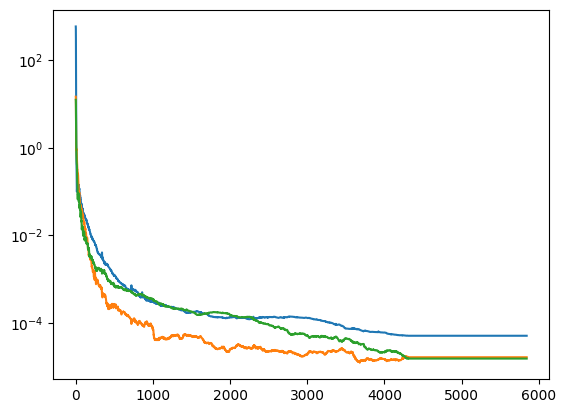

In [17]:
plt.plot(np.array(loss_track))
plt.yscale('log')

In [18]:
# Prepare the test data
Xt_u_test = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_true = usol.flatten('F')[:, None]


Xt_u_test = make_time_sequence(Xt_u_test, num_step=5, step=1e-4)
Xt_u_test = torch.from_numpy(Xt_u_test).float().to(device)
u_true = torch.from_numpy(u_true).float().to(device)

#print(Xt_u_test.shape)

#print(u_true.shape)
# Predict u using the trained PINN model
u_pred_test = model(Xt_u_test[:,:,0:1],Xt_u_test[:,:,1:2])

#print(u_pred_test.shape)
# Calculate the relative L2 error between predicted and true values
#error_vector = torch.linalg.norm((u_true - u_pred_test), 2) / torch.linalg.norm(u_true, 2)
#print(f"Test Error: {error_vector.item():.5f}")


In [19]:
u_true = u_true.flatten()

u_pred_test = u_pred_test[:,0,:].flatten()

error_vector = torch.linalg.norm((u_true - u_pred_test), 2) / torch.linalg.norm(u_true, 2)
print(f"Test Error: {error_vector.item():.5f}")

Test Error: 0.02717


In [20]:
def solution_plot(u_pred, usol, x, t, X, T, X_u_train, u_train):

    fig = plt.figure(figsize=(9, 9))  # Adjust the figure size
    gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1])
    fig.subplots_adjust(hspace=0.4)  # Add more space between subplots

    # Plot u(x, t)
    ax = plt.subplot(gs[0])
    h = ax.imshow(u_pred, interpolation='nearest', cmap='rainbow',
                  extent=[T.min(), T.max(), X.min(), X.max()],
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)

    ax.plot(X_u_train[:, 1], X_u_train[:, 0], 'kx',
            label='Data (%d points)' % u_train.shape[0],
            markersize=4, clip_on=False)

    for time_step in [25, 50, 75]:
        ax.plot(t[time_step] * np.ones((2, 1)), np.linspace(x.min(), x.max(), 2),
                'w-', linewidth=1)

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc='upper right')
    ax.set_title('$u(x,t)$ - PINN solution', fontsize=12)

    # Plot error
    ax = plt.subplot(gs[1])
    error = np.abs(usol - u_pred)
    h = ax.imshow(error, interpolation='nearest', cmap='rainbow',
                  extent=[T.min(), T.max(), X.min(), X.max()],
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)

    ax.plot(X_u_train[:, 1], X_u_train[:, 0], 'kx',
            label='Data (%d points)' % u_train.shape[0],
            markersize=4, clip_on=False)

    for time_step in [25, 50, 75]:
        ax.plot(t[time_step] * np.ones((2, 1)), np.linspace(x.min(), x.max(), 2),
                'w-', linewidth=1)

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc='best')
    ax.set_title('Error', fontsize=12)

    # u(x,t) slices
    gs2 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[2], wspace=0.5)

    time_steps = [25, 50, 75]
    titles = ['$t = 0.25s$', '$t = 0.50s$', '$t = 0.75s$']
    ax.legend(frameon=False, loc='upper right')
    for i, time_step in enumerate(time_steps):
        ax = plt.subplot(gs2[0, i])
        ax.plot(x, usol.T[time_step, :], 'b-', linewidth=2, label='Exact')
        ax.plot(x, u_pred.T[time_step, :], 'r--', linewidth=2, label='Prediction')
        ax.set_xlabel('$x$')
        ax.set_ylabel('$u(x,t)$')
        ax.set_xlim([-1.1, 1.1])
        ax.set_ylim([-1.1, 1.1])
        ax.set_title(titles[i], fontsize=10)
        ax.axis('square')

        #if i == 1:
        #    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=2, frameon=False)

    plt.show()

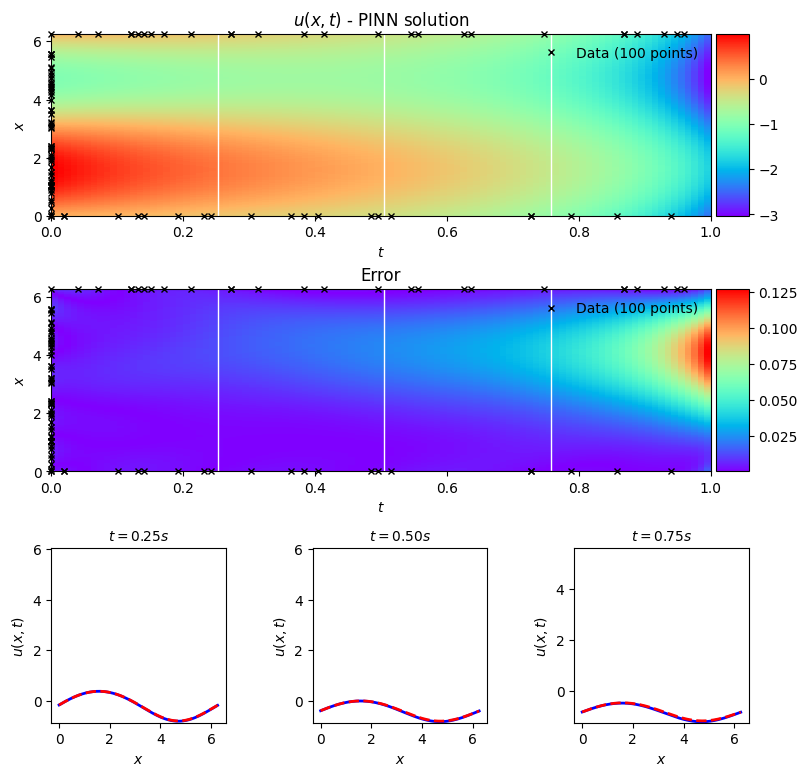

In [21]:
# Plot the solution
solution_plot(u_pred_test.cpu().detach().numpy().reshape((256, 100), order='F'),
                 usol, x, t, X, T, Xt_u_train, u_train)


## The use of PINNsFormer has significantly enhanced the learning performance for the (1.2) Reaction-Diffusion equation, reducing the test error from 0.24739 to 0.02717 (-89%). Additionally, the plot clearly shows a much closer match to the exact solution.
